In [27]:
# pip install datasets umap-learn pycddlib dask dask-expr cvxopt
from datasets import load_dataset
import os
import importlib
import urllib.request
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.ipc as ipc
import dask.dataframe as dd

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.spatial import ConvexHull
from scipy import stats

import polytope as pc
importlib.reload(pc)

from pypoman import compute_polytope_vertices
from pypoman import plot_polygon, project_polytope
from pypoman import compute_polytope_halfspaces

import cdd

from umap import UMAP

import manifold

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

Create a dataframe containing the 16 reflexive 2D polytopes, see the paper [Unconditional Reflexive Polytopes](https://link.springer.com/article/10.1007/s00454-020-00199-8) of Florian Kohl, McCabe Olsen and Raman Sanyal.

In [28]:
polytope_data = [
    {"id": 1, "num_vertices": 3, "vertices": [[-1,2],[2,-1],[-1,-1]]},
    {"id": 2, "num_vertices": 3, "vertices": [[0,1],[1,0],[-1,-1]]},
    {"id": 3, "num_vertices": 3, "vertices": [[0,1],[2,-1],[-2,-1]]},
    {"id": 4, "num_vertices": 3, "vertices": [[0,1],[1,-1],[-1,-1]]},
    {"id": 5, "num_vertices": 4, "vertices": [[-1,1],[1,1],[1,-1],[-1,-1]]},
    {"id": 6, "num_vertices": 4, "vertices": [[0,1],[1,0],[0,-1],[-1,0]]},
    {"id": 7, "num_vertices": 5, "vertices": [[0,1],[1,0],[1,-1],[-1,-1],[-1,1]]},
    {"id": 8, "num_vertices": 5, "vertices": [[0,1],[1,0],[0,-1],[-1,-1],[-1,0]]},
    {"id": 9, "num_vertices": 4, "vertices": [[0,1],[2,-1],[-1,-1],[-1,1]]},
    {"id": 10, "num_vertices": 4, "vertices": [[0,1],[1,0],[0,-1],[-1,-1]]},
    {"id": 11, "num_vertices": 4, "vertices": [[0,1],[2,-1],[-1,-1],[-1,0]]},
    {"id": 12, "num_vertices": 4, "vertices": [[0,1],[1,0],[1,-1],[-1,-1]]},
    {"id": 13, "num_vertices": 3, "vertices": [[0,1],[2,-1],[-1,-1]]},
    {"id": 14, "num_vertices": 4, "vertices": [[0,1],[1,-1],[-1,-1],[-1,1]]},
    {"id": 15, "num_vertices": 5, "vertices": [[0,1],[1,0],[1,-1],[-1,-1],[-1,0]]},
    {"id": 16, "num_vertices": 6, "vertices": [[0,1],[1,0],[1,-1],[0,-1],[-1,0],[1,1]]}
]

df_poly2d = pd.DataFrame(polytope_data)
print(df_poly2d)

    id  num_vertices                                           vertices
0    1             3                       [[-1, 2], [2, -1], [-1, -1]]
1    2             3                         [[0, 1], [1, 0], [-1, -1]]
2    3             3                        [[0, 1], [2, -1], [-2, -1]]
3    4             3                        [[0, 1], [1, -1], [-1, -1]]
4    5             4               [[-1, 1], [1, 1], [1, -1], [-1, -1]]
5    6             4                 [[0, 1], [1, 0], [0, -1], [-1, 0]]
6    7             5       [[0, 1], [1, 0], [1, -1], [-1, -1], [-1, 1]]
7    8             5       [[0, 1], [1, 0], [0, -1], [-1, -1], [-1, 0]]
8    9             4               [[0, 1], [2, -1], [-1, -1], [-1, 1]]
9   10             4                [[0, 1], [1, 0], [0, -1], [-1, -1]]
10  11             4               [[0, 1], [2, -1], [-1, -1], [-1, 0]]
11  12             4                [[0, 1], [1, 0], [1, -1], [-1, -1]]
12  13             3                        [[0, 1], [2, -1], [-

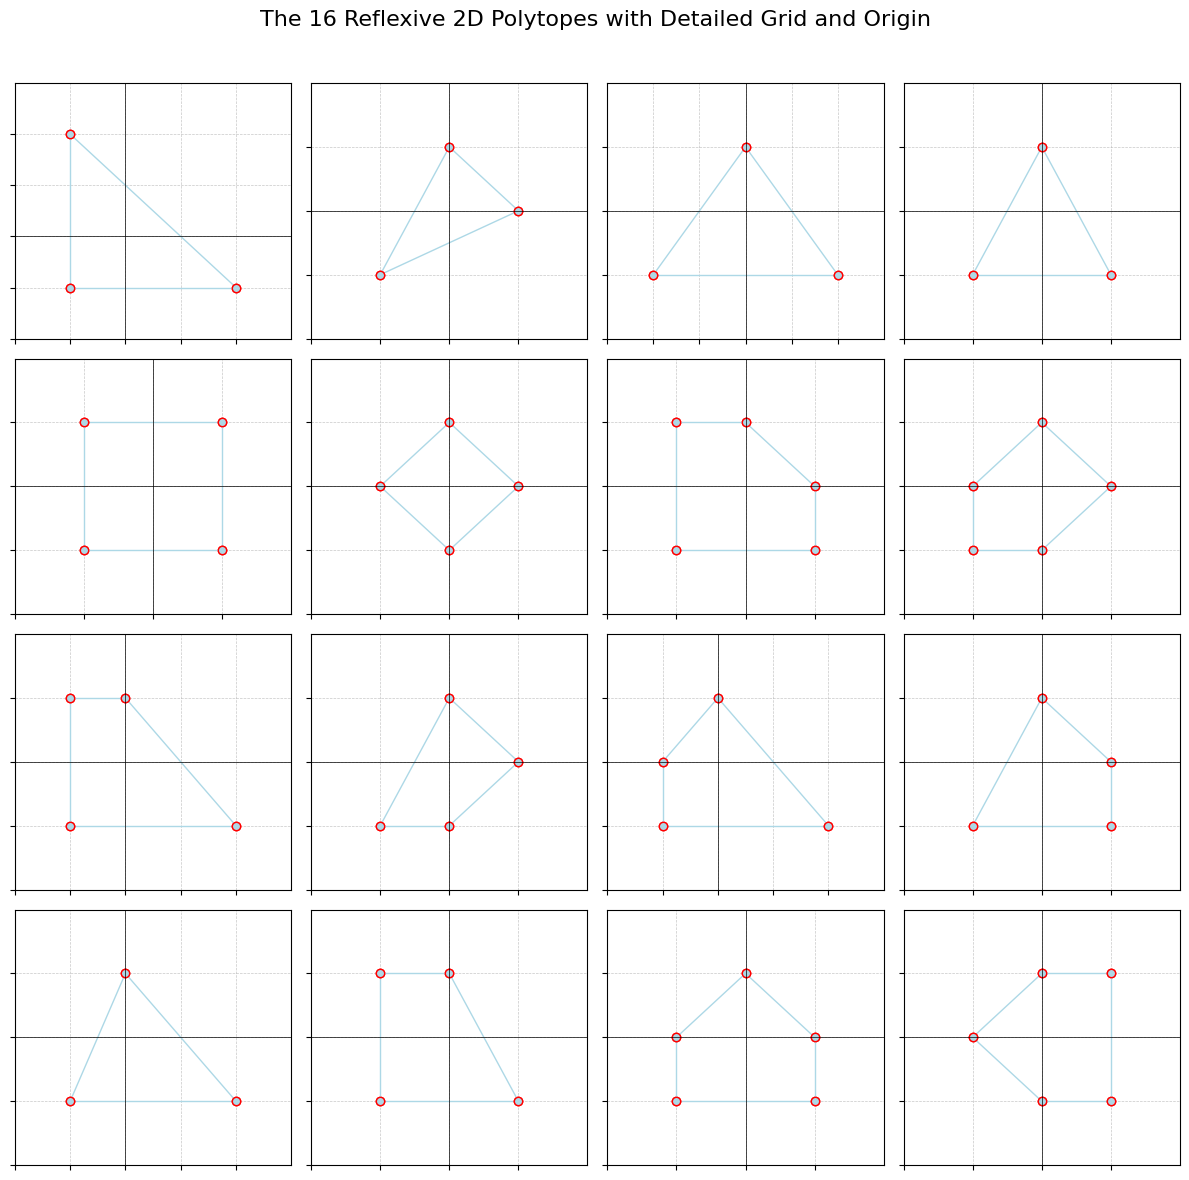

In [29]:
fig, axes = plt.subplots(4, 4, figsize=(12, 12))
fig.suptitle("16 Reflexive 2D Polytopes", fontsize=16)

for i, (index, row) in enumerate(df_poly2d.iterrows()):
    ax = axes[i // 4, i % 4]  # Determine row and column index in 4x4 grid
    
    # Extract vertices and convert to NumPy array
    V = np.array(row['vertices'])
    
    # Compute convex hull using scipy's ConvexHull
    hull = ConvexHull(V)
    
    # Plot the polytope by drawing each hull edge
    for simplex in hull.simplices:
        ax.plot(V[simplex, 0], V[simplex, 1], 'o-', color="lightblue", markeredgecolor="red", linewidth=1)
    
    # Add origin and detailed grid
    ax.axhline(0, color='black', linewidth=0.5)
    ax.axvline(0, color='black', linewidth=0.5)
    ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Set axis limits
    min_V = np.min(V, axis=0)
    max_V = np.max(V, axis=0)
    min_x, min_y = min_V[0] - 1, min_V[1] - 1
    max_x, max_y = max_V[0] + 1, max_V[1] + 1
    
    ax.set_xticks(range(min_x, max_x, 1))
    ax.set_yticks(range(min_y, max_y, 1))
    ax.set_xlim([min_x, max_x])
    ax.set_ylim([min_y, max_y])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.axis("on")

# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0, 1, 0.96])
fig.suptitle("The 16 Reflexive 2D Polytopes with Detailed Grid and Origin", fontsize=16)
plt.show()

Download the [list of all 4319](http://hep.itp.tuwien.ac.at/%7Ekreuzer/pub/K3/RefPoly.d3) reflexive 3D polytopes from M. Kreuzer, H. Skarke (TU Wien), see [landing page](http://hep.itp.tuwien.ac.at/~kreuzer/CY/CYk3.html).

In [30]:
file_path = r"C:\Users\esultano\git\polytopes\data\tuwien\RefPoly.d3"
file_url = "http://hep.itp.tuwien.ac.at/~kreuzer/pub/K3/RefPoly.d3"

if not os.path.exists(file_path):
    print("File not found. Downloading now...")
    # Create directories if they don't exist
    os.makedirs(os.path.dirname(file_path), exist_ok=True)
    
    # Download the file
    urllib.request.urlretrieve(file_url, file_path)
    print("Download completed.")
else:
    print("File already exists at the specified location.")

File already exists at the specified location.


In [31]:
data = {
    "dimension": [],
    "num_vertices": [],
    "m_lattice_points": [],
    "m_vertices": [],
    "n_lattice_points": [],
    "n_vertices": [],
    "picard_number": [],
    "correction": [],
    "vertices": []
}

with open(file_path, 'r') as file:
    while True:
        line = file.readline()
        if not line:
            break

        # Check for the start of a new polytope entry
        if line.startswith("3 "):  # Starts with "3" for dimension 3 polytopes
            # Parse the metadata line
            parts = line.split()
            dimension = int(parts[0])
            num_vertices = int(parts[1])
            m_lattice_points = int(parts[2][2:])  # Extract number after "M:"
            m_vertices = int(parts[3])
            n_lattice_points = int(parts[4][2:])  # Extract number after "N:"
            n_vertices = int(parts[5])
            picard_number = int(parts[6][4:])     # Extract number after "Pic:"
            correction = int(parts[7][4:])        # Extract number after "Cor:"

            # Store the metadata
            data["dimension"].append(dimension)
            data["num_vertices"].append(num_vertices)
            data["m_lattice_points"].append(m_lattice_points)
            data["m_vertices"].append(m_vertices)
            data["n_lattice_points"].append(n_lattice_points)
            data["n_vertices"].append(n_vertices)
            data["picard_number"].append(picard_number)
            data["correction"].append(correction)
            
            # Read the next 3 lines for vertex coordinates
            vertices = []
            for _ in range(3):
                vertex_line = file.readline().strip()
                # Convert vertex line to a list of integers
                vertex = list(map(int, vertex_line.split()))
                vertices.append(vertex)
            data["vertices"].append(vertices)

# Convert to DataFrame and check results
df_poly3d = pd.DataFrame(data)
print(df_poly3d['num_vertices'].value_counts())  # Check distribution
print(df_poly3d.head())

num_vertices
8     1051
7      964
9      801
6      611
10     405
5      250
11     143
4       48
12      37
13       8
14       1
Name: count, dtype: int64
   dimension  num_vertices  m_lattice_points  m_vertices  n_lattice_points  \
0          3             4                 5           4                35   
1          3             4                35           4                 5   
2          3             4                 6           4                30   
3          3             4                30           4                 6   
4          3             4                 9           4                21   

   n_vertices  picard_number  correction  \
0           4             19           0   
1           4              1           0   
2           4             18           2   
3           4              4           2   
4           4             16           6   

                                        vertices  
0  [[1, 0, 0, -1], [0, 1, 0, -1], [0, 0, 1, -1]]  
1  [

In [32]:
dataset = load_dataset("calabi-yau-data/polytopes-4d", cache_dir="C:/Users/esultano/git/polytopes/data/huggingface", split="full").shuffle(seed=42)
print("Verfügbare Aufteilungen:", dataset)

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/30 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/237 [00:00<?, ?it/s]

Verfügbare Aufteilungen: Dataset({
    features: ['vertices', 'vertex_count', 'facet_count', 'point_count', 'dual_point_count', 'h11', 'h12', 'euler_characteristic'],
    num_rows: 473800776
})


In [33]:
percentage = 0.01
chunk_size = 10000
max_dfs = 3
sample_size = int(percentage * len(dataset))

dfs = []
for i in range(0, min(sample_size, max_dfs * chunk_size), chunk_size):
    chunk = dataset.select(range(i, min(i + chunk_size, sample_size)))
    dfs.append(chunk.to_pandas())

df_poly4d = pd.concat(dfs, ignore_index=True)

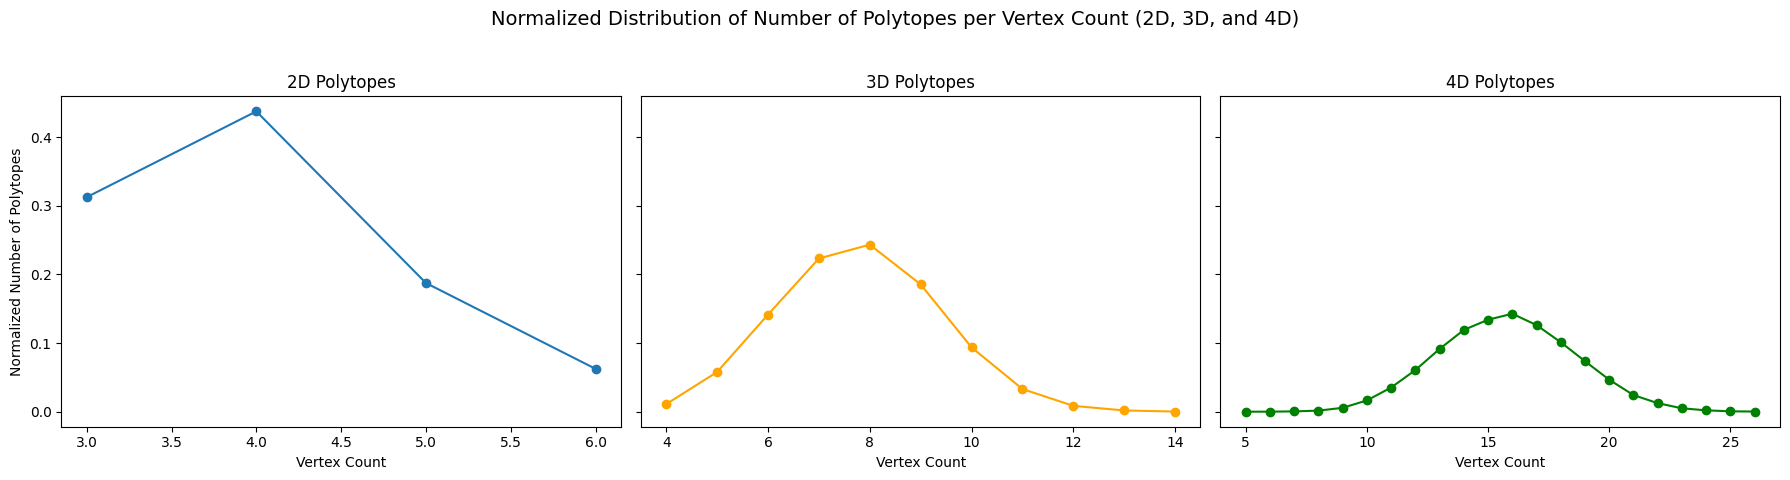

In [34]:
vertex_count_distribution_2d = df_poly2d['num_vertices'].value_counts().sort_index()
vertex_count_distribution_3d = df_poly3d['num_vertices'].value_counts().sort_index()
vertex_count_distribution_4d = df_poly4d['vertex_count'].value_counts().sort_index()

# Normalize the distributions
vertex_count_distribution_2d_norm = vertex_count_distribution_2d / vertex_count_distribution_2d.sum()
vertex_count_distribution_3d_norm = vertex_count_distribution_3d / vertex_count_distribution_3d.sum()
vertex_count_distribution_4d_norm = vertex_count_distribution_4d / vertex_count_distribution_4d.sum()

# Plotting the normalized distributions in separate charts (matrix style)
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

axes[0].plot(vertex_count_distribution_2d_norm.index, vertex_count_distribution_2d_norm.values, marker='o')
axes[0].set_title("2D Polytopes")
axes[0].set_xlabel("Vertex Count")
axes[0].set_ylabel("Normalized Number of Polytopes")

axes[1].plot(vertex_count_distribution_3d_norm.index, vertex_count_distribution_3d_norm.values, marker='o', color="orange")
axes[1].set_title("3D Polytopes")
axes[1].set_xlabel("Vertex Count")

axes[2].plot(vertex_count_distribution_4d_norm.index, vertex_count_distribution_4d_norm.values, marker='o', color="green")
axes[2].set_title("4D Polytopes")
axes[2].set_xlabel("Vertex Count")

fig.suptitle("Normalized Distribution of Number of Polytopes per Vertex Count (2D, 3D, and 4D)", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [35]:
def fit_distributions(data, dist_names=['norm', 'expon', 'gamma', 'beta', 'lognorm']):
    best_fit_name = None
    best_fit_params = None
    best_sse = np.inf  # Smallest sum of squared errors
    
    # Try each distribution
    for dist_name in dist_names:
        dist = getattr(stats, dist_name)
        params = dist.fit(data)  # Fit the distribution to data
        
        # Calculate the sum of squared errors (SSE)
        sse = np.sum((data - dist.pdf(data, *params)) ** 2)
        
        # Check if the current distribution has a better fit
        if sse < best_sse:
            best_fit_name = dist_name
            best_fit_params = params
            best_sse = sse
            
    return best_fit_name, best_fit_params

Best fit for 2D polytopes: norm with parameters (4.0, 2.23606797749979)


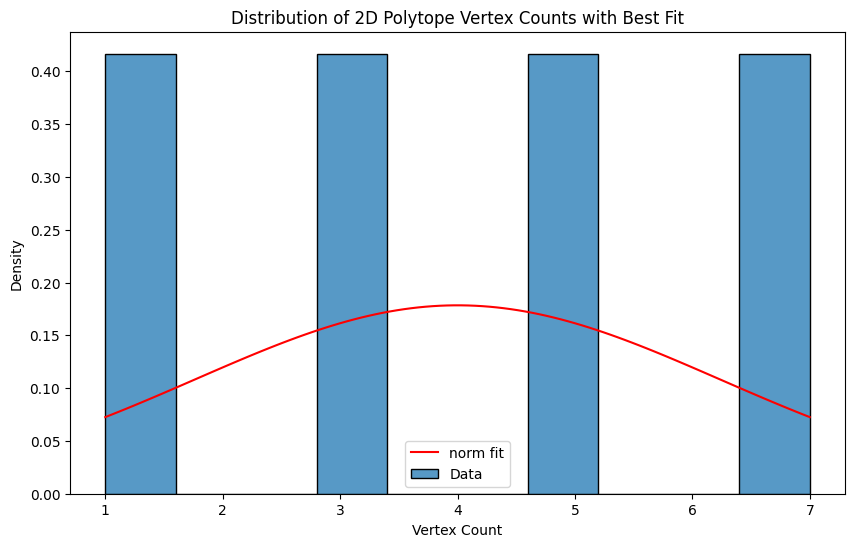

In [36]:
# Get the distribution for 2D polytopes as an example
data_2d = df_poly2d['num_vertices'].value_counts().values
best_fit_name_2d, best_fit_params_2d = fit_distributions(data_2d)

# Display the best fit result
print(f"Best fit for 2D polytopes: {best_fit_name_2d} with parameters {best_fit_params_2d}")

# Visualize the best fit along with the data
plt.figure(figsize=(10, 6))
sns.histplot(data_2d, kde=False, stat="density", label="Data", bins=10)

# Plot the best fitting distribution
dist = getattr(stats, best_fit_name_2d)
x = np.linspace(min(data_2d), max(data_2d), 100)
pdf_fitted = dist.pdf(x, *best_fit_params_2d)
plt.plot(x, pdf_fitted, label=f"{best_fit_name_2d} fit", color="red")

plt.title("Distribution of 2D Polytope Vertex Counts with Best Fit")
plt.xlabel("Vertex Count")
plt.ylabel("Density")
plt.legend()
plt.show()

Best fit for 3D polytopes: norm with parameters (392.6363636363636, 381.82986995097286)


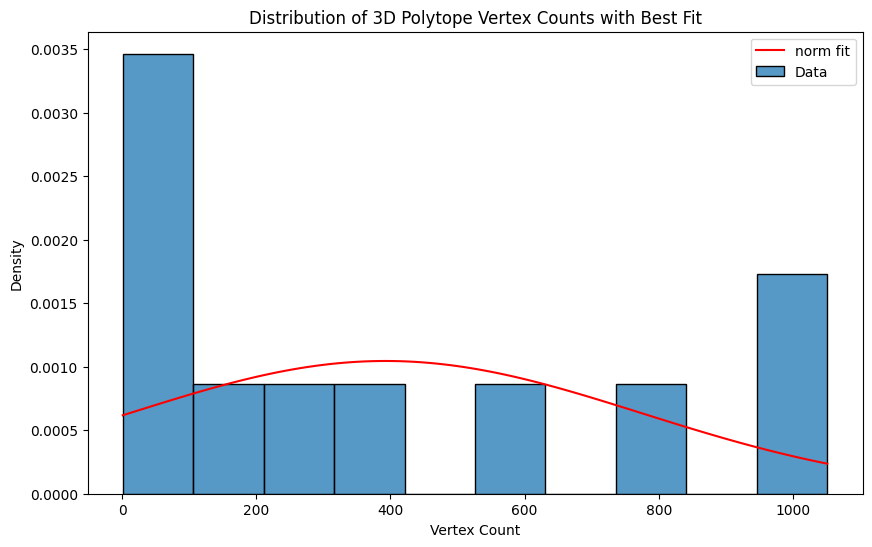

In [37]:
# Get the distribution for 2D polytopes as an example
data_3d = df_poly3d['num_vertices'].value_counts().values
best_fit_name_3d, best_fit_params_3d = fit_distributions(data_3d)

# Display the best fit result
print(f"Best fit for 3D polytopes: {best_fit_name_3d} with parameters {best_fit_params_3d}")

# Visualize the best fit along with the data
plt.figure(figsize=(10, 6))
sns.histplot(data_3d, kde=False, stat="density", label="Data", bins=10)

# Plot the best fitting distribution
dist = getattr(stats, best_fit_name_3d)
x = np.linspace(min(data_3d), max(data_3d), 100)
pdf_fitted = dist.pdf(x, *best_fit_params_3d)
plt.plot(x, pdf_fitted, label=f"{best_fit_name_3d} fit", color="red")

plt.title("Distribution of 3D Polytope Vertex Counts with Best Fit")
plt.xlabel("Vertex Count")
plt.ylabel("Density")
plt.legend()
plt.show()

Best fit for 4D polytopes: norm with parameters (1363.6363636363637, 1502.7267200130973)


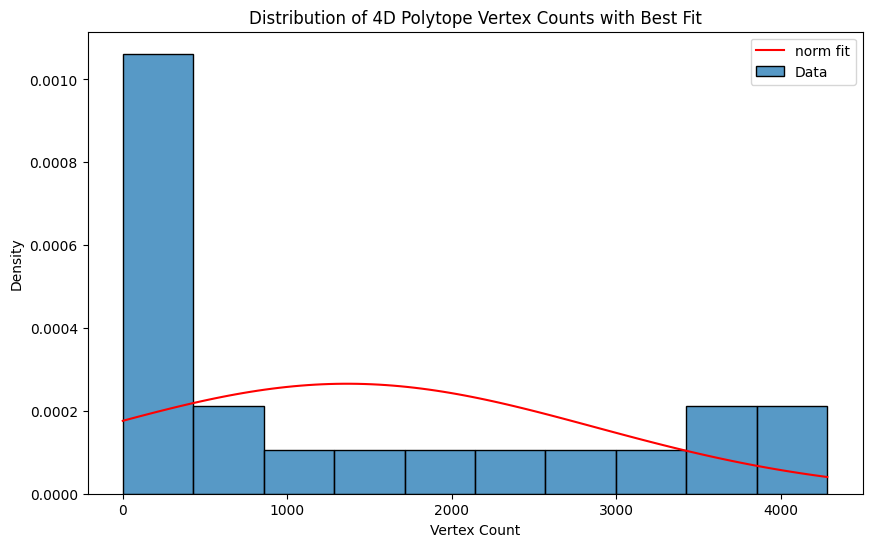

In [38]:
# Get the distribution for 2D polytopes as an example
data_4d = df_poly4d['vertex_count'].value_counts().values
best_fit_name_4d, best_fit_params_4d = fit_distributions(data_4d)

# Display the best fit result
print(f"Best fit for 4D polytopes: {best_fit_name_4d} with parameters {best_fit_params_4d}")

# Visualize the best fit along with the data
plt.figure(figsize=(10, 6))
sns.histplot(data_4d, kde=False, stat="density", label="Data", bins=10)

# Plot the best fitting distribution
dist = getattr(stats, best_fit_name_4d)
x = np.linspace(min(data_4d), max(data_4d), 100)
pdf_fitted = dist.pdf(x, *best_fit_params_4d)
plt.plot(x, pdf_fitted, label=f"{best_fit_name_4d} fit", color="red")

plt.title("Distribution of 4D Polytope Vertex Counts with Best Fit")
plt.xlabel("Vertex Count")
plt.ylabel("Density")
plt.legend()
plt.show()